In [1]:
import polars as pl

import rustystats as rs

data = pl.read_parquet("https://raw.githubusercontent.com/PricingFrontier/pricing-data-example/917c853e256df8d5814721ab56f72889a908bb08/data/processed/frequency_set.parquet")

In [2]:
exploration = rs.explore_data(
    data=data,
    response="ClaimCount",
    categorical_factors=["Region", "Area"],
    continuous_factors=["VehPower", "VehAge"],
    exposure="Exposure",
)

In [3]:
exploration.to_json()

'{"data_summary": {"n_rows": 678012, "n_columns": 13, "response_column": "ClaimCount", "exposure_column": "Exposure", "n_categorical_factors": 2, "n_continuous_factors": 2}, "factor_stats": [{"name": "VehPower", "type": "continuous", "mean": 6.454630596508617, "std": 2.050905590758379, "min": 4.0, "max": 15.0, "missing_count": 0, "missing_pct": 0.0, "response_by_bin": [{"bin_index": 1, "bin_lower": 4.0, "bin_upper": 5.0, "count": 115349, "exposure": 60073.637303557, "response_sum": 5605.0, "response_rate": 0.09330215801113352}, {"bin_index": 3, "bin_lower": 5.0, "bin_upper": 6.0, "count": 124821, "exposure": 68173.348820864, "response_sum": 7159.0, "response_rate": 0.10501171093723703}, {"bin_index": 5, "bin_lower": 6.0, "bin_upper": 7.0, "count": 148976, "exposure": 82524.210171993, "response_sum": 8260.0, "response_rate": 0.10009183950727797}, {"bin_index": 7, "bin_lower": 7.0, "bin_upper": 8.0, "count": 145400, "exposure": 77949.53670018699, "response_sum": 7503.0, "response_rate": 

In [4]:
model = rs.glm(
    formula="ClaimCount ~ VehPower + VehAge + C(Area) + C(Region)",
    data=data,
    family="poisson",
    offset="Exposure"
).fit()

In [27]:
print(model.summary())

                                 GLM Results                                  

Family:              QuasiPoisson    No. Observations:        678012
Link Function:       (default)       Df Residuals:            677984
Method:              IRLS            Df Model:                    27
Scale:               2.5391          Iterations:                   6

Log-Likelihood:         -946300.1047 Deviance:                217974.0393
AIC:                    1892656.2094 Null Deviance:            37380.9687
BIC:                    1892976.1632 Pearson chi2:             1721477.12
Converged:           True           

------------------------------------------------------------------------------
Variable                             Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept                         -2.2522     0.1439  -15.654  <0.0001   [ -2.5342,  -1.9702]  ***
VehPower                   

In [36]:
# Predict on the data
predictions = model.predict(data, offset="Exposure")
print(f"Predictions shape: {predictions.shape}")
print(f"Mean predicted claim rate: {predictions.mean():.6f}")
print(f"Min: {predictions.min():.6f}, Max: {predictions.max():.6f}")

Predictions shape: (678012,)
Mean predicted claim rate: 0.052943
Min: 0.000020, Max: 0.267777


In [37]:
predictions

array([0.06261984, 0.01230509, 0.09993619, ..., 0.07276209, 0.05764911,
       0.07149573], shape=(678012,))

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Add predictions to data for plotting
plot_data = data.with_columns([
    pl.lit(predictions).alias("Predicted"),
    pl.col("ClaimCount").alias("Actual")
])

def plot_ae_chart(
    data: pl.DataFrame,
    factor: str,
    bins: list = None,
    use_rate: bool = False,
    figsize: tuple = (12, 4),
    title: str = None,
):
    """
    Plot Actual vs Expected chart with exposure bars and A/E ratio.
    
    Parameters
    ----------
    data : pl.DataFrame
        Data with 'Actual', 'Predicted', and 'Exposure' columns.
    factor : str
        Column name to group by.
    bins : list, optional
        For continuous factors, bin edges. If None, treats factor as categorical.
    use_rate : bool
        If True, plot rates (per exposure) instead of counts.
    figsize : tuple
        Figure size.
    title : str, optional
        Custom title. Defaults to factor name.
    """
    # Bin continuous factors if bins provided
    if bins is not None:
        bin_col = f"{factor}_bin"
        grouped = data.with_columns([
            pl.col(factor).cut(bins).alias(bin_col)
        ]).group_by(bin_col).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.col("Exposure").sum().alias("Exposure")
        ]).sort(bin_col)
        labels = [str(b) for b in grouped[bin_col].to_list()]
    else:
        grouped = data.group_by(factor).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.col("Exposure").sum().alias("Exposure")
        ]).sort(factor)
        labels = [str(v) for v in grouped[factor].to_list()]
    
    # Calculate A/E and rates
    grouped = grouped.with_columns([
        (pl.col("Actual") / pl.col("Expected")).alias("A/E"),
        (pl.col("Actual") / pl.col("Exposure")).alias("Actual_Rate"),
        (pl.col("Expected") / pl.col("Exposure")).alias("Expected_Rate")
    ])
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    x = np.arange(len(labels))
    
    # Left: Exposure bar with Actual/Expected lines
    ax1 = axes[0]
    ax2 = ax1.twinx()
    
    ax1.bar(x, grouped["Exposure"].to_numpy(), alpha=0.3, color="gray", label="Exposure")
    ax1.set_ylabel("Exposure", color="gray")
    ax1.tick_params(axis="y", labelcolor="gray")
    ax1.set_ylim(bottom=0)
    
    if use_rate:
        y_actual = grouped["Actual_Rate"].to_numpy()
        y_expected = grouped["Expected_Rate"].to_numpy()
        y_label = "Claim Rate"
    else:
        y_actual = grouped["Actual"].to_numpy()
        y_expected = grouped["Expected"].to_numpy()
        y_label = "Claim Count"
    
    ax2.plot(x, y_actual, "o-", color="steelblue", linewidth=2, markersize=8, label="Actual")
    ax2.plot(x, y_expected, "s--", color="coral", linewidth=2, markersize=8, label="Expected")
    ax2.set_ylabel(y_label, color="black")
    ax2.set_ylim(bottom=0)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    ax1.set_xlabel(title or factor)
    ax1.set_title(f"Actual vs Expected by {title or factor}")
    ax2.legend(loc="upper left")
    
    # Right: A/E ratio
    ae_vals = grouped["A/E"].to_numpy()
    colors = ["green" if 0.95 <= v <= 1.05 else "orange" if 0.9 <= v <= 1.1 else "teal" for v in ae_vals]
    axes[1].bar(labels, ae_vals, color=colors)
    axes[1].axhline(y=1.0, color="red", linestyle="--", label="Perfect calibration")
    axes[1].set_xticks(range(len(labels)))
    axes[1].set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    axes[1].set_xlabel(title or factor)
    axes[1].set_ylabel("A/E Ratio")
    axes[1].set_title(f"A/E Ratio by {title or factor}")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return grouped

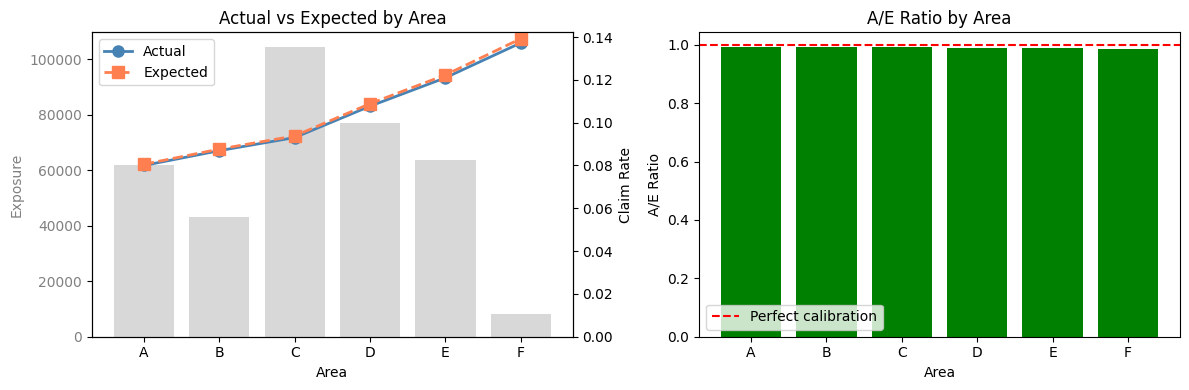

Area,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
str,i32,f64,f64,f64,f64,f64
"""A""",4958,4992.789712,61969.377712,0.993032,0.080007,0.080569
"""B""",3739,3770.077701,43012.323931,0.991757,0.086929,0.087651
"""C""",9719,9798.180077,104449.003784,0.991919,0.09305,0.093808
"""D""",8307,8397.419939,77119.271692,0.989232,0.107716,0.108889
"""E""",7721,7805.524356,63819.31427,0.989171,0.120982,0.122307
"""F""",1116,1131.96512,8129.234074,0.985896,0.137282,0.139246


In [39]:
# Actual vs Expected by Area
plot_ae_chart(plot_data, "Area", use_rate=True)

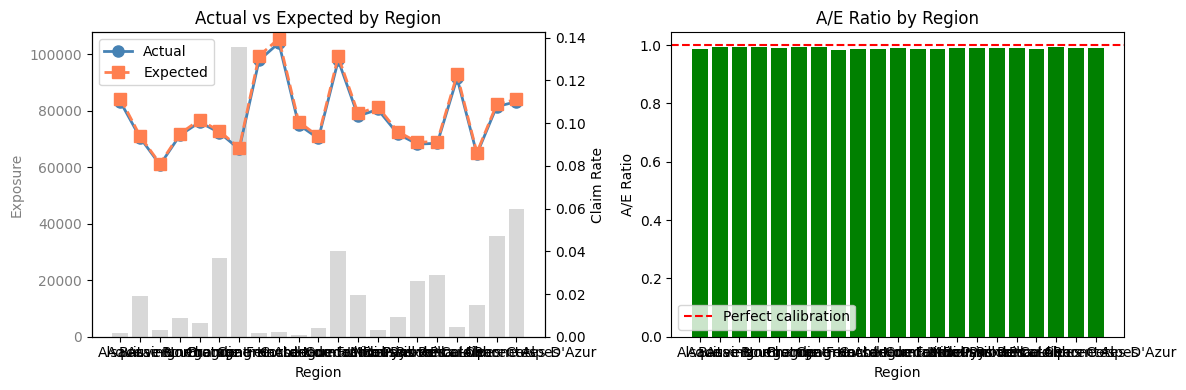

Region,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
str,i32,f64,f64,f64,f64,f64
"""Alsace""",133,134.881844,1209.115823,0.986048,0.109998,0.111554
"""Aquitaine""",1334,1344.573741,14322.166692,0.992136,0.093142,0.093881
"""Auvergne""",187,188.166117,2322.884229,0.993803,0.080503,0.081005
"""Basse-Normandie""",628,632.908944,6657.901142,0.992244,0.094324,0.095061
"""Bourgogne""",505,510.502382,5025.358609,0.989222,0.10049,0.101585
…,…,…,…,…,…,…
"""Pays-de-la-Loire""",1987,2004.664822,21934.031165,0.991188,0.09059,0.091395
"""Picardie""",433,438.987106,3574.410221,0.986362,0.121139,0.122814
"""Poitou-Charentes""",955,962.559396,11163.408715,0.992147,0.085547,0.086225


In [40]:
# Actual vs Expected by Region
plot_ae_chart(plot_data, "Region", use_rate=True)

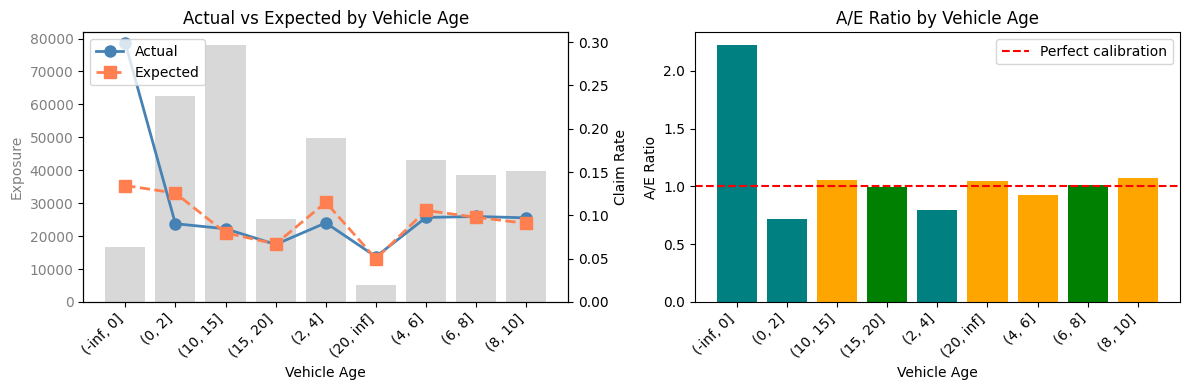

VehAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 0]""",4996,2247.076525,16719.028729,2.223333,0.298821,0.134402
"""(0, 2]""",5641,7848.312293,62457.026619,0.718753,0.090318,0.125659
"""(10, 15]""",6588,6222.176528,77990.975407,1.058793,0.084471,0.079781
"""(15, 20]""",1668,1682.315597,25136.158607,0.991491,0.066359,0.066928
"""(2, 4]""",4550,5731.546489,49841.358576,0.793852,0.09129,0.114996
"""(20, inf]""",269,256.148491,5147.215965,1.050172,0.052261,0.049764
"""(4, 6]""",4193,4542.361751,42987.678107,0.923088,0.09754,0.105667
"""(6, 8]""",3797,3760.542438,38486.488979,1.009695,0.098658,0.097711
"""(8, 10]""",3858,3605.476794,39732.594475,1.070039,0.097099,0.090744


In [41]:
# Actual vs Expected by VehAge (binned)
plot_ae_chart(plot_data, "VehAge", bins=[0, 2, 4, 6, 8, 10, 15, 20], use_rate=True, title="Vehicle Age")

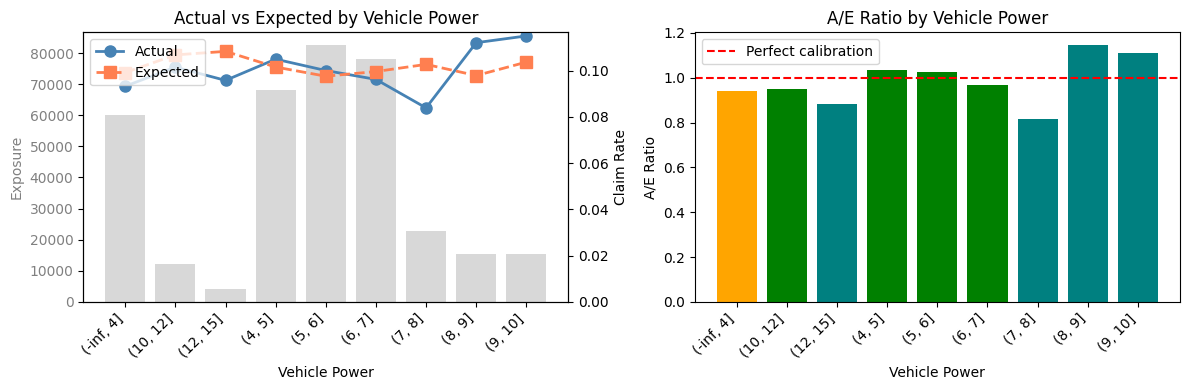

VehPower_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 4]""",5605,5960.263101,60073.637304,0.940395,0.093302,0.099216
"""(10, 12]""",1248,1313.163905,12289.816795,0.950376,0.101547,0.10685
"""(12, 15]""",391,442.190903,4080.134886,0.884233,0.09583,0.108377
"""(4, 5]""",7159,6926.658286,68173.348821,1.033543,0.105012,0.101604
"""(5, 6]""",8260,8056.817417,82524.210172,1.025219,0.100092,0.09763
"""(6, 7]""",7503,7768.297906,77949.5367,0.965849,0.096255,0.099658
"""(7, 8]""",1904,2330.840016,22684.616305,0.816873,0.083934,0.10275
"""(8, 9]""",1721,1502.965465,15348.213656,1.14507,0.11213,0.097924
"""(9, 10]""",1769,1594.759906,15375.010824,1.109258,0.115057,0.103724


In [42]:
# Actual vs Expected by VehPower (binned)
plot_ae_chart(plot_data, "VehPower", bins=[4, 5, 6, 7, 8, 9, 10, 12, 15], use_rate=True, title="Vehicle Power")

In [13]:
# Get diagnostics object
diag = model.diagnostics(
    data=data,
    categorical_factors=["Region", "Area"],
    continuous_factors=["VehPower", "VehAge"]
)

# Export as JSON for LLM consumption
json_output = diag.to_json()

In [26]:
model = rs.glm(
    formula="ClaimCount ~ VehPower + VehAge + C(Area) + C(Region)",
    data=data,
    family="quasipoisson",
    offset="Exposure",
).fit()

In [35]:
model = rs.glm(
    formula="ClaimCount ~ VehPower + VehAge + C(Area) + C(Region)",
    data=data,
    family="negbinomial",
    offset="Exposure"
).fit()

In [16]:
print(model.summary())

                                 GLM Results                                  

Family:              NegativeBinomial(theta=1.3802) No. Observations:        678012
Link Function:       (default)       Df Residuals:            677984
Method:              IRLS            Df Model:                    27
Scale:               0.2902          Iterations:                   6

Log-Likelihood:         -268022.9580 Deviance:                196741.4284
AIC:                     536101.9160 Null Deviance:            37380.9687
BIC:                     536421.8697 Pearson chi2:               37376.61
Converged:           True           

------------------------------------------------------------------------------
Variable                             Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept                         -2.2351     0.0498  -44.854  <0.0001   [ -2.3328,  -2.1375]  ***
VehPower    

In [59]:
data.columns

['IDpol',
 'VehPower',
 'VehAge',
 'DrivAge',
 'BonusMalus',
 'VehBrand',
 'VehGas',
 'Area',
 'Density',
 'Region',
 'Group',
 'Exposure',
 'ClaimCount']

In [64]:
formula = """
    ClaimCount ~
    ns(VehPower, df=4) +
    ns(VehAge, df=4) +
    ns(DrivAge, df=4) +
    ns(BonusMalus, df=4) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    ns(Density, df=4) +
    TE(Region)
"""

model = rs.glm(
    formula=formula,
    data=data,
    family="poisson",
    offset="Exposure"
).fit()

ValueError: GLM fitting failed: Linear algebra error: Failed to solve weighted least squares - matrix may be singular. This often indicates multicollinearity in predictors.

In [63]:
print(model.summary())

                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            678002
Method:              IRLS            Df Model:                     9
Scale:               1.0000          Iterations:                   7

Log-Likelihood:         -142432.1573 Deviance:                215864.1685
AIC:                     284884.3147 Null Deviance:           214041.4441
BIC:                     284998.5839 Pearson chi2:             1633007.12
Converged:           True           

------------------------------------------------------------------------------
Variable                Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept            -3.3164     0.0832  -39.871  <0.0001   [ -3.4794,  -3.1534]  ***
bs(VehAge, 2/5)      -1.3307     0.0258  -51.614  <0.

In [54]:
# Predict on the data
predictions = model.predict(data, offset="Exposure")
print(f"Predictions shape: {predictions.shape}")
print(f"Mean predicted claim rate: {predictions.mean():.6f}")
print(f"Min: {predictions.min():.6f}, Max: {predictions.max():.6f}")

plot_data = data.with_columns([
    pl.lit(predictions).alias("Predicted"),
    pl.col("ClaimCount").alias("Actual")
])

Predictions shape: (678012,)
Mean predicted claim rate: 0.052618
Min: 0.000001, Max: 0.442386


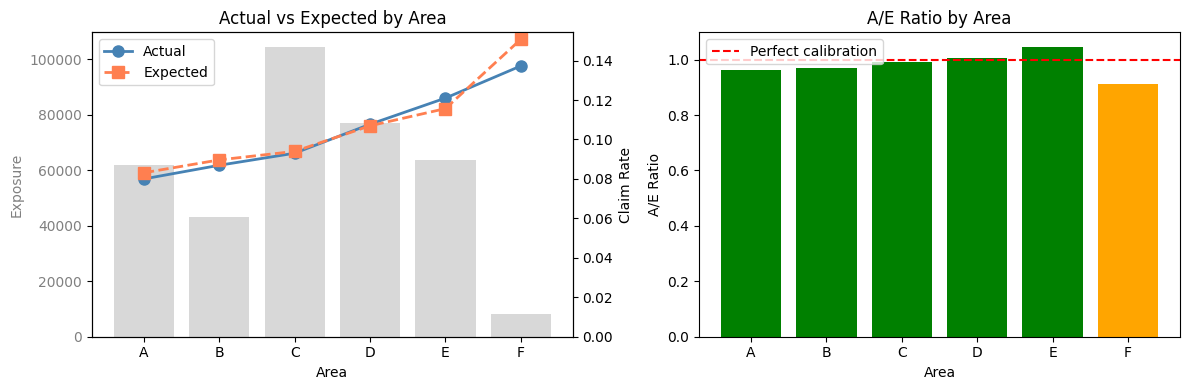

Area,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
str,i32,f64,f64,f64,f64,f64
"""A""",4958,5151.290064,61969.377712,0.962477,0.080007,0.083126
"""B""",3739,3856.421301,43012.323931,0.969552,0.086929,0.089659
"""C""",9719,9813.588749,104449.003785,0.990361,0.09305,0.093956
"""D""",8307,8247.304764,77119.271692,1.007238,0.107716,0.106942
"""E""",7721,7381.454015,63819.31427,1.046,0.120982,0.115662
"""F""",1116,1225.772146,8129.234074,0.910447,0.137282,0.150786


In [55]:
plot_ae_chart(plot_data, "Area", use_rate=True)

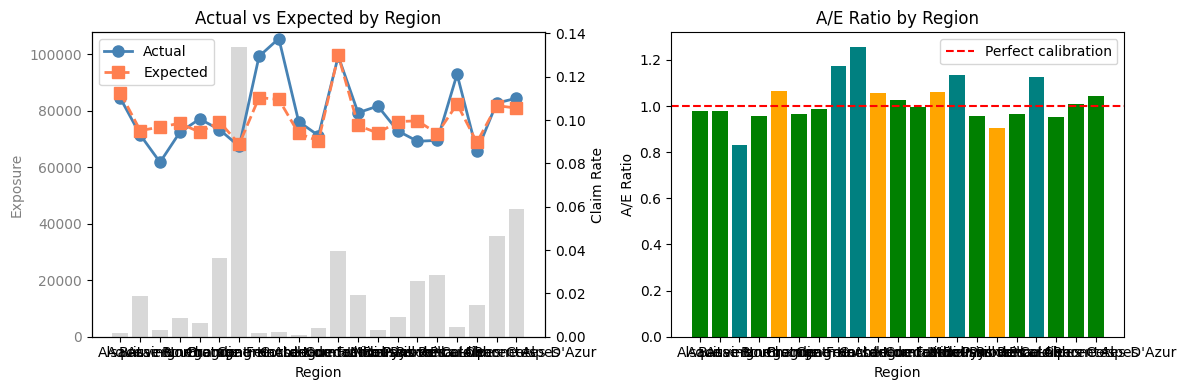

Region,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
str,i32,f64,f64,f64,f64,f64
"""Alsace""",133,135.950438,1209.115823,0.978298,0.109998,0.112438
"""Aquitaine""",1334,1362.449072,14322.166692,0.979119,0.093142,0.095129
"""Auvergne""",187,224.731446,2322.884229,0.832104,0.080503,0.096747
"""Basse-Normandie""",628,655.701412,6657.901142,0.957753,0.094324,0.098485
"""Bourgogne""",505,474.388328,5025.358609,1.064529,0.10049,0.094399
…,…,…,…,…,…,…
"""Pays-de-la-Loire""",1987,2056.636995,21934.031165,0.96614,0.09059,0.093765
"""Picardie""",433,383.811593,3574.410221,1.128158,0.121139,0.107378
"""Poitou-Charentes""",955,1001.244424,11163.408715,0.953813,0.085547,0.08969


In [56]:
plot_ae_chart(plot_data, "Region", use_rate=True)

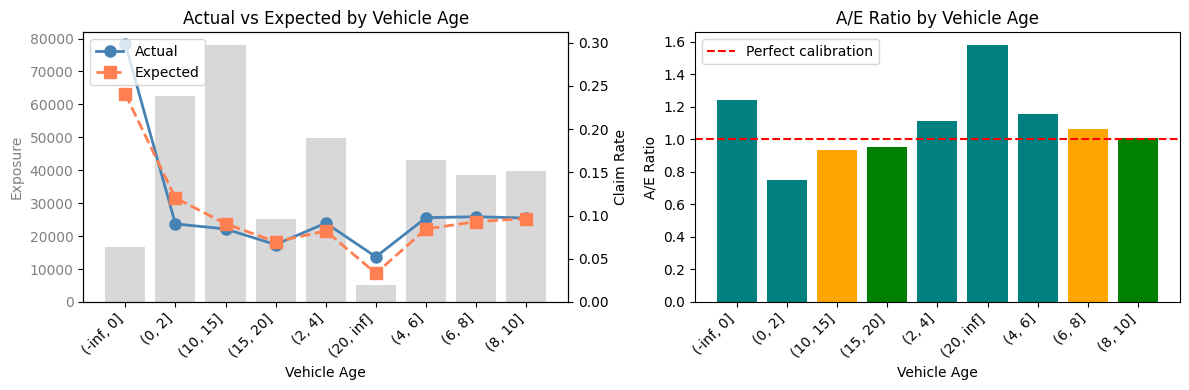

VehAge_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 0]""",4996,4023.586506,16719.028729,1.241678,0.298821,0.240659
"""(0, 2]""",5641,7521.41633,62457.026619,0.749992,0.090318,0.120425
"""(10, 15]""",6588,7066.041615,77990.975407,0.932347,0.084471,0.090601
"""(15, 20]""",1668,1749.026383,25136.158607,0.953673,0.066359,0.069582
"""(2, 4]""",4550,4099.092837,49841.358576,1.110002,0.09129,0.082243
"""(20, inf]""",269,170.442617,5147.215965,1.578244,0.052261,0.033114
"""(4, 6]""",4193,3632.982151,42987.678107,1.154148,0.09754,0.084512
"""(6, 8]""",3797,3575.825513,38486.488979,1.061853,0.098658,0.092911
"""(8, 10]""",3858,3837.417087,39732.594475,1.005364,0.097099,0.096581


In [57]:
# Actual vs Expected by VehAge (binned)
plot_ae_chart(plot_data, "VehAge", bins=[0, 2, 4, 6, 8, 10, 15, 20], use_rate=True, title="Vehicle Age")

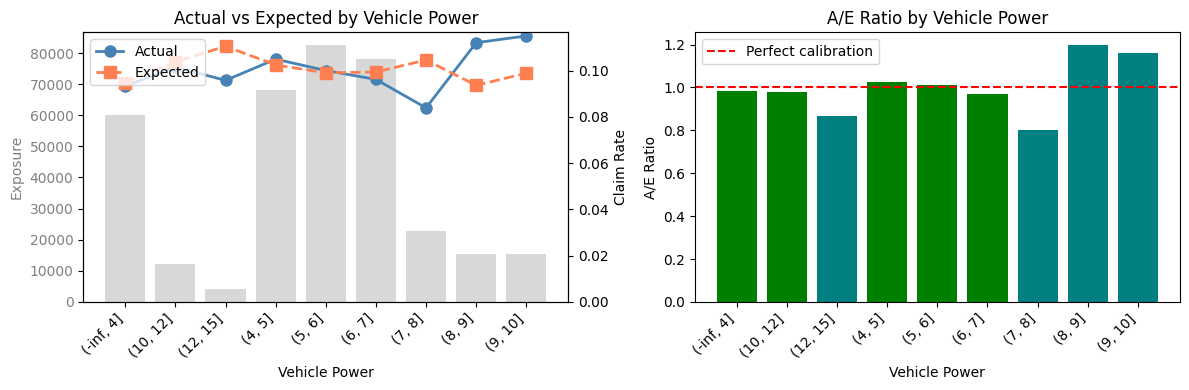

VehPower_bin,Actual,Expected,Exposure,A/E,Actual_Rate,Expected_Rate
cat,i32,f64,f64,f64,f64,f64
"""(-inf, 4]""",5605,5696.168873,60073.637304,0.983995,0.093302,0.09482
"""(10, 12]""",1248,1276.078088,12289.816795,0.977997,0.101547,0.103832
"""(12, 15]""",391,451.183733,4080.134886,0.866609,0.09583,0.110581
"""(4, 5]""",7159,6989.386305,68173.348821,1.024267,0.105012,0.102524
"""(5, 6]""",8260,8177.160576,82524.210172,1.010131,0.100092,0.099088
"""(6, 7]""",7503,7752.653145,77949.5367,0.967798,0.096255,0.099457
"""(7, 8]""",1904,2373.619704,22684.616305,0.80215,0.083934,0.104636
"""(8, 9]""",1721,1437.900965,15348.213656,1.196884,0.11213,0.093685
"""(9, 10]""",1769,1521.679649,15375.010824,1.162531,0.115057,0.098971


In [58]:
# Actual vs Expected by VehPower (binned)
plot_ae_chart(plot_data, "VehPower", bins=[4, 5, 6, 7, 8, 9, 10, 12, 15], use_rate=True, title="Vehicle Power")

In [19]:
# Continuous × Continuous interaction (main effects + interaction)
result = rs.glm(
    "ClaimCount ~ VehAge*VehPower",  # Equivalent to Age + VehPower + Age:VehPower
    data, family="poisson", offset="Exposure"
).fit()

print(result.summary())

                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            678008
Method:              IRLS            Df Model:                     3
Scale:               1.0000          Iterations:                   6

Log-Likelihood:         -143853.3626 Deviance:                218706.5790
AIC:                     287714.7251 Null Deviance:           214041.4441
BIC:                     287760.4328 Pearson chi2:             1743718.16
Converged:           True           

------------------------------------------------------------------------------
Variable               Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept           -1.9977     0.0273  -73.205  <0.0001   [ -2.0512,  -1.9442]  ***
VehAge              -0.0513     0.0033  -15.588  <0.000

In [20]:
# Categorical × Continuous interaction
result = rs.glm(
    "ClaimCount ~ C(Area)*VehAge",  # Each area level has different age effect
    data, family="poisson", offset="Exposure"
).fit()

print(result.summary())

                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            678000
Method:              IRLS            Df Model:                    11
Scale:               1.0000          Iterations:                   6

Log-Likelihood:         -143552.3722 Deviance:                218104.5983
AIC:                     287128.7445 Null Deviance:           214041.4441
BIC:                     287265.8675 Pearson chi2:             1727075.48
Converged:           True           

------------------------------------------------------------------------------
Variable               Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept           -2.2116     0.0243  -90.924  <0.0001   [ -2.2593,  -2.1639]  ***
Area[T.B]            0.0291     0.0367    0.794   0.427

In [21]:
# Categorical × Categorical interaction
result = rs.glm(
    "ClaimCount ~ C(Area)*C(VehBrand)",
    data, family="poisson", offset="Exposure"
).fit()

print(result.summary())

                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            677946
Method:              IRLS            Df Model:                    65
Scale:               1.0000          Iterations:                   6

Log-Likelihood:         -143819.8831 Deviance:                218639.6201
AIC:                     287771.7662 Null Deviance:           214041.4441
BIC:                     288525.9430 Pearson chi2:             1709888.91
Converged:           True           

------------------------------------------------------------------------------
Variable                        Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept                    -2.5768     0.0264  -97.511  <0.0001   [ -2.6286,  -2.5250]  ***
Area[T.B]                     0.0711 

In [22]:
# Pure interaction (no main effects added)
result = rs.glm(
    "ClaimCount ~ VehAge + C(Area):VehPower",  # Area-specific VehPower slopes
    data, family="poisson", offset="Exposure"
).fit()

In [23]:
print(result.summary())

                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            678005
Method:              IRLS            Df Model:                     6
Scale:               1.0000          Iterations:                   6

Log-Likelihood:         -143616.1679 Deviance:                218232.1896
AIC:                     287246.3358 Null Deviance:           214041.4441
BIC:                     287326.3242 Pearson chi2:             1735303.91
Converged:           True           

------------------------------------------------------------------------------
Variable                 Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept             -2.1616     0.0134 -161.427  <0.0001   [ -2.1878,  -2.1354]  ***
VehAge                -0.0373     0.0010  -35.720  

In [51]:
result = rs.glm(
    "ClaimCount ~ bs(VehAge, df=5) + C(Region) + C(Area):VehPower + C(Area)*C(VehBrand)",
    data, 
    family="poisson"
).fit()

plot_data = data.with_columns([
    pl.lit(predictions).alias("Predicted"),
    pl.col("ClaimCount").alias("Actual")
])

In [25]:
print(result.summary())

                                 GLM Results                                  

Family:              Poisson         No. Observations:        678012
Link Function:       (default)       Df Residuals:            677917
Method:              IRLS            Df Model:                    94
Scale:               1.0000          Iterations:                   7

Log-Likelihood:         -140446.6874 Deviance:                211893.2287
AIC:                     281083.3749 Null Deviance:           214041.4441
BIC:                     282168.9323 Pearson chi2:              732945.27
Converged:           True           

------------------------------------------------------------------------------
Variable                             Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept                         -2.5263     0.0926  -27.297  <0.0001   [ -2.7077,  -2.3449]  ***
Region[T.Aquitaine]        